# Case Study Part 2: Insights
This notebook is running on a Google Colab L4 CPU environment. In this section, the metrics inferred from the data in part 1 of the case study are clustered, analyzed and visualized.

In [2]:
%%capture
#!pip install numpy --upgrade #(uncomment install lines if running first time in google colab)
#!pip install scipy --upgrade
#!pip install gensim #(refresh kernel after installing to load new library and recomment installs)

In [1]:
%%capture
import pandas as pd
import gensim #gensim is used for a latent text embedding model for clustering text by meaning
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from matplotlib import pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud

In [2]:
from gensim.models.phrases import Phrases
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import numpy as np

In [3]:
%%capture
!pip install datasets
from datasets import load_dataset

In [4]:
data = load_dataset("skeskinen/TinyStories-GPT4")

README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

(…)-00000-of-00008-c63ccd5d5290f4a1.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00001-of-00008-478199d8ac044910.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00002-of-00008-9b868f59be94d815.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00003-of-00008-d183cca02834cd90.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00004-of-00008-5f8ac0bb66de5834.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00005-of-00008-e8c22c3e776b87dd.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00006-of-00008-941f57106aca3340.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00007-of-00008-771d8aa2d5ce5c95.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2745100 [00:00<?, ? examples/s]

In [5]:
data_df = data['train'].to_pandas()

In [6]:
word_occurrences = pd.read_csv('word_occurrences.csv')

In [7]:
feature_occurrences = pd.read_csv('feature_occurrences.csv')

# Statistical Analysis and Visualization
In this section the statistical metrics calculated from the training data is analyzed and visualized for making insights with regards to the stated objectives. Furthermore, given the complexity in understanding the level of literacy from the data - as no 'literacy level' column is within the data - a language model is used to classify the responses.

## Mental Health
As for mental-health, goals may be defined in objective terms by inferring the emotions, subjects, topics, genres, or any commonly used keywords related to mental-health within the data. For this purpose, we can use the list of words and narrative features provided within the prompts provided to the AI in the training data for each row in the dataset. By counting the occurrences of the 'words' and 'features' columns used within the prompt, we can make some insights of the mental-health objectives.

### Objective: Highlight narrative features that relate to mental health.

#### Narrative Features
Some of the 'feature narrative' words provided to the model within the prompt template's in the training dataset give insight into whether the story may contain any emotional subjects or topics related to mental health. A bar plot is shown that highlights the amount of each feature narrative.

In [8]:
# converting the counts of feature occurrences to probability values
feature_occurence_probabilities = feature_occurrences['feature_occurrences'] / feature_occurrences['feature_occurrences'].sum()

In [9]:
feature_occurence_probabilities.index = feature_occurrences['feature']

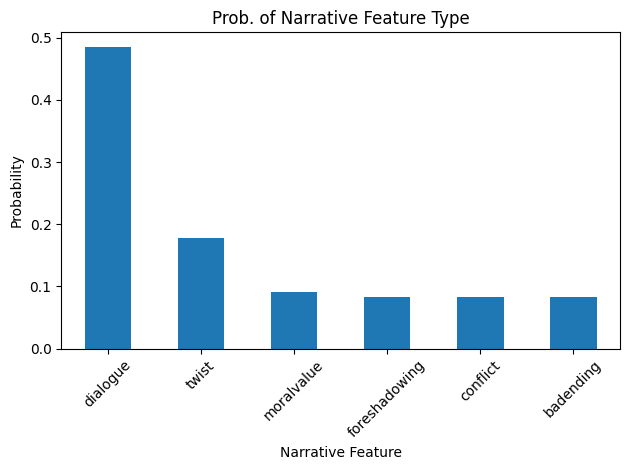

In [10]:
ax = feature_occurence_probabilities.sort_values(ascending=False).plot(
    kind='bar',
    title='Prob. of Narrative Feature Type'
)

# Correctly set labels using set methods
plt.ylabel('Probability')
plt.xlabel('Narrative Feature')
plt.xticks(rotation=45)

# Optional: Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [11]:
feature_occurrences.describe()

,feature_occurrences
count,6.000000e+00
mean,5.059540e+05
std,4.859297e+05
min,2.503000e+05
25%,2.507192e+05
50%,2.624705e+05
75%,4.730752e+05
max,1.470404e+06


##### **Mental Health Insight**
We can see from the bar chart that the majority of narratives have dialogue (i.e speech between characters in a story). Similarly, 'twists' and 'moralvalue' are 2nd and 3rd respectively, highlighting how the majority of prompts seek to generate interesting stories where characters interact and exemplify moral values. On the other end of the spectrum, the story prompts in the training data generate stories with narratives like foreshadowing, conflict, and bad endings. As our target demographic is youth, it might be a good idea to do further investigation on story prompts that contain the 'conflict' and 'badending' narrative tags - these combined tags are contained in roughly **20%** of the prompts.

##### **Statistical Insight**
The description of the feature occurrences show that the average count of prompts with each narrative type is typically ~500,000 for each. However, the 50% quantile is ~260,000 showing that the majority of narrative types are roughly half as large as the mean. This implies that there are outlier narratives skewing the distribution up. The 'dialogue' and 'twist' narrative types are outliers, and are contained within ~50% and ~20% of the story prompts respectively, and combined contribute to ~70% of the story prompts. Similarly, the standard deviation value of ~480,000 shows how the variation in prompt counts is really high, further showing how the outliers ('dialogue', 'twist') are overshadowing the remaining narrative types ('moralvalue', 'foreshadowing', 'conflict', 'badending').

**Note**: Most of the prompts range in number of narrative tags, and may contain either none or all of the tags described above. As such, it is worth investigating how these tags correlate. For example, a combined 'badending' and 'conflict' narrative lacking a 'moralvalue' tag might lead to risky or insensitive storytelling.

#### Key Words
The key words column 'words' in the data are specific key vocabulary words provided to the AI in the story generation prompt. These words differ from the narrative feature words as the key words must be included in the generated story - whereas the narrative features are abstract storytelling features.

In [12]:
# converting the counts of feature occurrences to probability values
word_occurrence_probabilities = word_occurrences['word_occurrences'] / word_occurrences['word_occurrences'].sum()

In [13]:
word_occurrence_probabilities.index = word_occurrences['word']

In [14]:
word_occurrence_probabilities.describe()

,word_occurrences
count,1603.000000
mean,0.000624
std,0.000422
min,0.000294
25%,0.000311
50%,0.000319
75%,0.000854
max,0.002497


As the collection of vocabulary words within the dataset is large (~1604), the data must be clustered along the words' sentiment/meaning using a text embedding model. This way, we can reduce the dimensionality of the data while somewhat preserving the intended meaning of the collection. Given the individual probabilities for each word are very small (on the scale of 1/1000 likeliness), clustering to reduce the dimensionality will help understand the salient groups of words that are commonly paired within each vocab key collection.

In [15]:
# step 1: prepare the n-grams
data_df['words'].head() # every collection of words is already of length 3 (trigram format)

,words
0,"[receive, opera, red]"
1,"[use, sheet, blue]"
2,"[relax, bus, uncomfortable]"
3,"[sail, cricket, wide]"
4,"[pray, pigeon, creative]"


Since the dataset is large, clustering can not be executed in one execution - even with Google Colabs biggest ram environment. Therefore, the data will be clustered in iterations via bootstrapping. In this way, the data will be clustered in batches and then aggregated.

In [16]:
# note: vectorizer must be initialized outside the loop
# in order to maintain the training data across batches

# Step 3: LDA Clustering the batched TF-IDF matrix with
def bootstrap_clustering(data, num_clusters, num_iterations, batch_size):
    """
    Performs bootstrapped clustering on the data, incorporating TF-IDF creation within the loop.

    Args:
        data: The data to cluster (the 'words' column of your DataFrame).
        num_topics: The number of clusters in the LDA clustering.
        num_iterations: The number of iterations.
        batch_size: The batch size.

    Returns:
        A list of cluster assignments for each data point.
    """

    all_topic_assignments = []
    batches = []
    topic_assignment_batches = []
    # Initialize lists to store cluster statistical metrics
    coherence_scores = []
    perplexity_scores = []

    data_size = len(data)

    for _ in range(num_iterations):
        # Randomly sample a batch of data
        batch_indices = np.random.choice(data_size, size=batch_size, replace=True)
        batch_data = data.iloc[batch_indices]['words']  # Select the 'words' column
        batches.append(batch_data)

        # Prepare data for LDA
        dictionary = Dictionary([word for word in batch_data.values])
        corpus = [dictionary.doc2bow(text) for text in batch_data.values]

        # Perform LDA on the batch
        lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=15, workers=2)
        batch_topic_assignments = [max(lda_model[doc], key=lambda item: item[1])[0] for doc in corpus]

        topic_assignment_batches.append(batch_topic_assignments)
        # Append the cluster assignments to the list
        all_topic_assignments.extend(batch_topic_assignments)
        # Calculate and store metrics for this iteration
        coherence_model = CoherenceModel(model=lda_model, texts=batch_data.values, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)

        perplexity = lda_model.log_perplexity(corpus)
        perplexity_scores.append(perplexity)

    return all_topic_assignments, batches, topic_assignment_batches, coherence_scores, perplexity_scores

In [17]:
num_topics = 10
num_iterations = 10  # Adjust as needed
batch_size = 2000  # This number is close to the maximum compute

# Perform bootstrapped clustering
topic_assignments, batches, topic_assignment_batches, coherence_scores, perplexity_scores = bootstrap_clustering(
    data_df, num_topics, num_iterations, batch_size
)

# Assign the cluster assignments to the original DataFrame
# word_trigram_df['cluster'] = cluster_assignments

In [18]:
cluster_assignments_df = pd.DataFrame(topic_assignments, columns=['topic'])
# adding in a cluster iteration index
cluster_assignments_df['iteration'] = cluster_assignments_df.index // batch_size

In [19]:
cluster_counts_by_iteration = cluster_assignments_df.groupby('iteration')['topic'].value_counts()

<Axes: xlabel='iteration'>

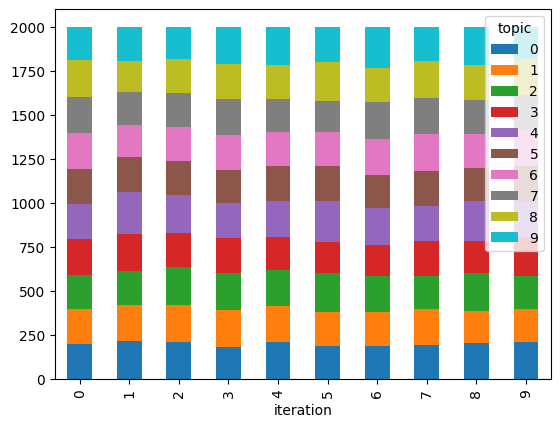

In [20]:
# let's visualize the distribution of cluster counts by iteration by showing a bar chart with a legend using the iteration
cluster_counts_by_iteration.unstack().plot(kind='bar', stacked=True, legend=True)

In [23]:
# creating a word cloud for the dominant and second-most dominant cluster across iterations
for i in range(len(batches)):
  # add the cluster labels to the batch
  batch = batches[i]
  # create a df with batch['words'] and  cluster_assignments[i*batch_size:(i+1)*batch_size] columns
  batch_df = pd.DataFrame({'words': batch, 'topic': topic_assignment_batches[i]})
  # group by cluster
  print(batch_df['topic'].value_counts())
  break
  #groupby cluster to create a df to calculate the values of each clusters frequency
  cluster_frequencies = batch_df.groupby('cluster').describe()
  print(cluster_frequencies)
  break
  # calculate the top 2 clusters
  cluster_counts = batch['cluster'].value_counts().sort_values(ascending=False)
  top_clusters = cluster_counts.head(2)
  # create a word cloud of the top clusters
  wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100)
  wordcloud.generate(' '.join(batch[batch['cluster'] == top_clusters.index[0]]['words'].values))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')

topic
8    207
3    207
7    206
6    203
4    200
0    199
5    198
1    196
2    193
9    191
Name: count, dtype: int64


##### Mental Health Insight


##### Statistical Insight

## Creativity
Objectively speaking, creativity is a hard goal to define as it can be objectively defined in a multitude of way, as are the aforementioned topics of literacy and mental-health. However, many people might agree that creativity is somehow unique. Therefore, it may be possible to define the goal of creativity by understanding the level of variance in the models responses to similar prompts.

### Narrative Features

### Key Words

## Literacy
WonderWords' literacy goals may be defined in objective terms by classifying whether the responses are at a lower or a higher reading level. As our application is targeting a youth demographic, utilizing the categorization system used in most libraries and school systems will help illustrate whether the training data is biased towards a specific set of reading levels.

### Narrative Features

### Key Words